In [7]:
import phoebe
from phoebe import u, c

import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

from analisis.phoebe_model.utils import *

logger = phoebe.logger(clevel='WARNING')

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/normalizedTimeseries.csv"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

if not os.path.exists("external-jobs"):
	os.mkdir("external-jobs")

## Observation Data

In [3]:
observations = pd.read_csv(CONCAT_OBSERVATIONS_CSV)
observations.head()

,time,mag,err,raw_flux,ferr,detrend_flux,norm_flux,obsv_date,julianDate
0,2022-10-21 22:54:21.841,18.014,0.014,37382.02,482.037653,3264.86,1.109233,2022-10-21,2.459874e+06
1,2022-10-21 22:55:22.219,18.044,0.012,36357.11,401.847030,2239.95,1.074942,2022-10-21,2.459874e+06
2,2022-10-21 22:56:22.714,18.019,0.013,37214.78,445.603887,3097.62,1.103637,2022-10-21,2.459874e+06
3,2022-10-21 22:57:23.081,18.006,0.010,37644.18,346.727273,3527.02,1.118004,2022-10-21,2.459874e+06
4,2022-10-21 22:58:23.606,18.035,0.009,36665.20,303.939210,2548.04,1.085250,2022-10-21,2.459874e+06


In [4]:
jdTime = observations['julianDate']
jdTimeMin, jdTimeMax = jdTime.iloc[0], jdTime.iloc[-1]
observations['julianDate_norm'] = (jdTime - jdTimeMin) / (jdTimeMax - jdTimeMin)
observations

,time,mag,err,raw_flux,ferr,detrend_flux,norm_flux,obsv_date,julianDate,julianDate_norm
0,2022-10-21 22:54:21.841,18.014,0.014,37382.02,482.037653,3264.86,1.109233,2022-10-21,2.459874e+06,0.000000
1,2022-10-21 22:55:22.219,18.044,0.012,36357.11,401.847030,2239.95,1.074942,2022-10-21,2.459874e+06,0.000014
2,2022-10-21 22:56:22.714,18.019,0.013,37214.78,445.603887,3097.62,1.103637,2022-10-21,2.459874e+06,0.000028
3,2022-10-21 22:57:23.081,18.006,0.010,37644.18,346.727273,3527.02,1.118004,2022-10-21,2.459874e+06,0.000042
4,2022-10-21 22:58:23.606,18.035,0.009,36665.20,303.939210,2548.04,1.085250,2022-10-21,2.459874e+06,0.000056
...,...,...,...,...,...,...,...,...,...,...
1172,2022-12-10 20:52:39.875,18.277,0.015,29324.09,405.140785,-5558.93,0.814015,2022-12-10,2.459924e+06,0.999944
1173,2022-12-10 20:53:40.007,18.267,0.018,29610.24,490.913070,-5272.78,0.823588,2022-12-10,2.459924e+06,0.999958
1174,2022-12-10 20:54:40.156,18.312,0.023,28412.02,601.894133,-6471.00,0.783500,2022-12-10,2.459924e+06,0.999972
1175,2022-12-10 20:55:40.318,18.343,0.017,27607.31,432.278042,-7275.71,0.756576,2022-12-10,2.459924e+06,0.999986


## PHOEBE initial setup

In [4]:
b = phoebe.default_contact_binary()

In [5]:
b.add_compute(
    compute='fast_compute',
    
    # speed up compute for the sake of the demo; DON'T PUBLISH WITH THESE
    irrad_method='none',
    rv_method='dynamical', # no meshing; compute rvs from first principles
    distortion_method='sphere',
    atm='blackbody',
    overwrite=True
)

<ParameterSet: 36 parameters | components: secondary, _default, contact_envelope, primary>

In [ ]:
computePhases = phoebe.linspace(0, 1, 16)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True)
print(b['mesh01'])

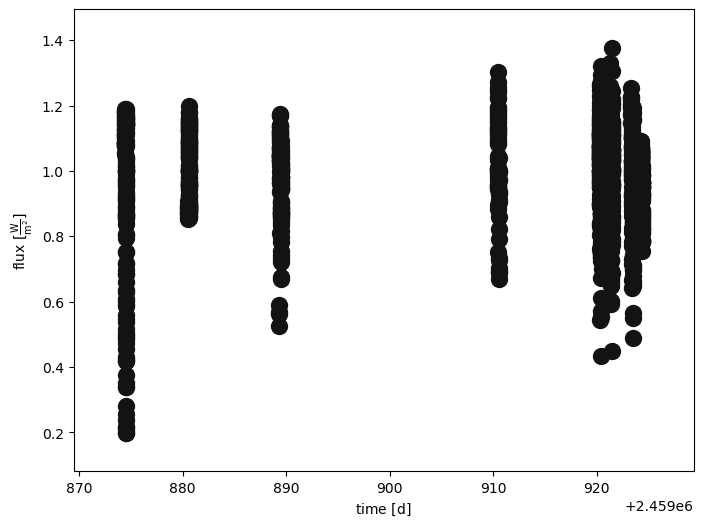

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [86]:
b.add_dataset('lc', times=jdTime.to_numpy()*u.day, fluxes=observations['norm_flux'].to_numpy(), dataset='lc_iturbide', overwrite=True)
# b.add_dataset('lc', times=jdTime.to_numpy()*u.day, fluxes=normFluxObservations['FLUX'].to_numpy(), dataset='lc_iturbide', overwrite=True)
# b.add_dataset('lc', times=observations['JDTIME_Norm'].to_numpy(), fluxes=normFluxObservations['FLUX'].to_numpy(), dataset='lc_iturbide', overwrite=True)
b.plot(dataset='lc_iturbide', show=True)

In [4]:
t0 = b.get_quantity(qualifier='t0_supconj')
computePhases = phoebe.linspace(0, 1, 16)
b.add_dataset('mesh', compute_times=b.to_time(computePhases), dataset='mesh01', columns=['teffs'], overwrite=True)
print(b['mesh01'])

ParameterSet: 9 parameters
     compute_times@mesh01@dataset: [0.         0.03333333 0.06666667 ...
 0.43333333 0.46666667 0.5       ] d
C   compute_phases@mesh01@dataset: [ 0.          0.06666667  0.13333333 ...
 -0.13333333 -0.06666667  0.        ]
         phases_t0@mesh01@dataset: t0_supconj
     include_times@mesh01@dataset: []
       coordinates@mesh01@dataset: ['xyz', 'uvw']
           columns@mesh01@dataset: ['teffs']
   enabled@mesh01@phoebe01@com...: True
   enabled@mesh01@fast_compute...: True
   compute_phases@mesh01@const...: times_to_phases({compute_times@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component})


In [5]:
b.save("./bundle-saves/default-iturbide-data")

'./bundle-saves/default-iturbide-data'

In [8]:
print(b['period@orbit'])
print(b['t0_supconj'])

Parameter: period@binary@component
                       Qualifier: period
                     Description: Orbital period (defined at t0@system, sidereal: wrt the sky)
                           Value: 0.5 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, period_anom@binary@component, mean_anom@binary@component, freq@binary@component, mass@primary@component, period@primary@component, mass@secondary@component, period@secondary@component, compute_phases@lc_iturbide@dataset
                      Related to: t0_supconj@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0@system, t0_perpass@binary@component, t0_ref@binary@component, period_anom@binary@component, mean_anom@binary@component, freq@binary@component, sma@binary@component, q@binary@component, mass@primary@component, syncpar@primary@component, period@primary@component, mass@secondary@component,

In [58]:
# TODO: research implications of choosing 'dataset-scaled' value for scaling
print(b['pblum_mode'])
print(b['passband'])

print(b['atm'])
print(b['ld_mode'])
print(b['ld_mode_bol'])

Parameter: pblum_mode@lc_iturbide@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: passband@lc_iturbide@dataset
                       Qualifier: passband
                     Description: Passband
                           Value: Johnson:V
                         Choices: PanStarrs:z, Johnson:R, Gaia:BP, PanStarrs:y, SWASP:default, Tycho:B, ZTF:g, LSST:r, PanStarrs:g, PanStarrs:w, Johnson:B, LSST:z, SDSS:rprime, Kepler:mean, SSDSS:us, ZTF:i, Johnson:I, Johnson:J, LSST:i, Cousins:I, SWASP:pre2004, SDSS:r, SDSS:g, SDSS:i, Stromgren:y, BRITE:blue, SDSS:gprime, Cousins:R, BRITE:red, Johnson:K, LSST:u, PanStarrs:i, SDSS:z, SSDSS:rs, S

## Load clean default PHOEBE bundle

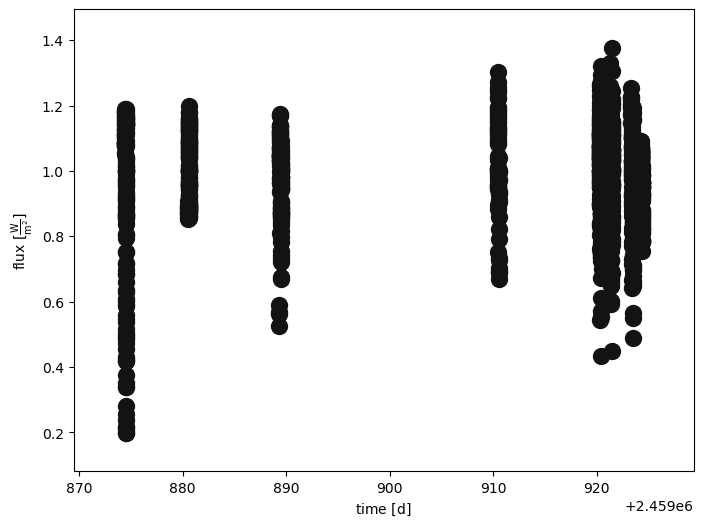

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [6]:
b = phoebe.load("./bundle-saves/default-iturbide-data")
b.plot(show=True)

In [7]:
print(b.computes)
print(b.datasets)
print(b.solutions)
print(b.models)
print(b.filter(dataset='mesh01').models)
print(b['period@binary'])

['phoebe01', 'fast_compute']
['lc_iturbide', 'mesh01']
[]
[]
[]
Parameter: period@binary@component
                       Qualifier: period
                     Description: Orbital period (defined at t0@system, sidereal: wrt the sky)
                           Value: 0.5 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, period_anom@binary@component, mean_anom@binary@component, freq@binary@component, mass@primary@component, period@primary@component, mass@secondary@component, period@secondary@component, compute_phases@lc_iturbide@dataset, compute_phases@mesh01@dataset
                      Related to: t0_supconj@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0@system, t0_perpass@binary@component, t0_ref@binary@component, period_anom@binary@component, mean_anom@binary@component, freq@binary@component, sma@binary@component, q@binary@component, mass@pr

## Period estimator
Utilizing Lomb-Scargle algorithm on the normalized light curve

In [8]:
b.add_solver('estimator.lc_periodogram', algorithm='ls', solver='lcperiod', overwrite=True)
b.run_solver('lcperiod', solution='lcperiod_solution', overwrite=True)

print(b['fitted_values@lcperiod_solution'])

Parameter: fitted_values@lcperiod_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [7.025483702780226]
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [9]:
print(b['lcperiod'])

ParameterSet: 18 parameters
         comments@lcperiod@solver: 
       use_server@lcperiod@solver: none
        algorithm@lcperiod@solver: ls
      lc_datasets@lcperiod@solver: ['*']
        component@lcperiod@solver: binary
      sample_mode@lcperiod@solver: auto
   samples_per_peak@lcperiod@s...: 10
   nyquist_factor@lcperiod@solver: 5
R  period@lcperiod_solution@so...: [ 0.08013098  0.08213425  0.08413753
 ... 23.57453442 23.5765377
 23.57854097] d
R  power@lcperiod_solution@sol...: [0.01651149 0.01238161 0.00812437 ...
 0.00300538 0.00106973 0.00015096]
   period_factor@lcperiod_solu...: 1.0
R  fitted_twigs@lcperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_solu...: [7.025483702780226]
R  fitted_units@lcperiod_solut...: ['d']
   adopt_parameters@lcperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_solut...: True
   comments@lcperiod_solution@...: 


ParameterSet: 10 parameters
R  period@lcperiod_solution@so...: [ 0.08013098  0.08213425  0.08413753
 ... 23.57453442 23.5765377
 23.57854097] d
R  power@lcperiod_solution@sol...: [0.01651149 0.01238161 0.00812437 ...
 0.00300538 0.00106973 0.00015096]
   period_factor@lcperiod_solu...: 1.0
R  fitted_twigs@lcperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_solu...: [7.025483702780226]
R  fitted_units@lcperiod_solut...: ['d']
   adopt_parameters@lcperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_solut...: True
   comments@lcperiod_solution@...: 


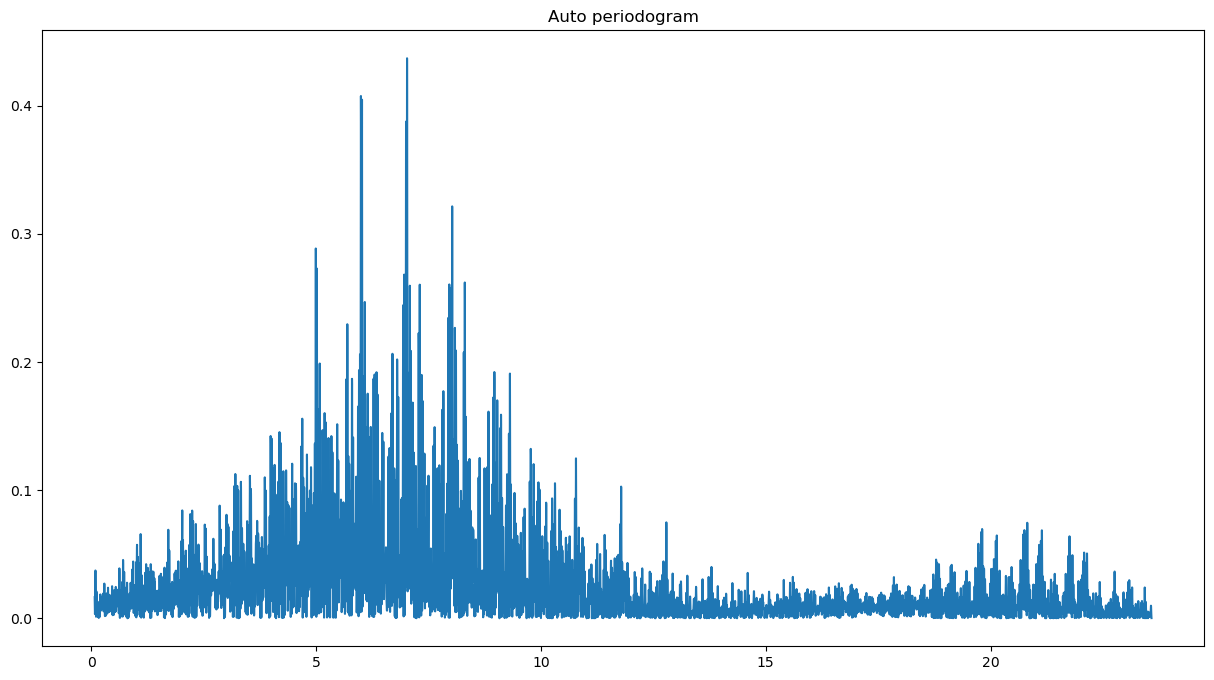

In [10]:
print(b['lcperiod_solution'])
plt.plot(b.get_value('period@lcperiod_solution'), b.get_value('power@lcperiod_solution'))
plt.title("Auto periodogram")
plt.show()

In [12]:
b.add_solver('estimator.lc_periodogram', algorithm='ls', solver='lcperiod_manual', overwrite=True)
b.set_value(qualifier='sample_mode', solver='lcperiod_manual', value='manual')
b.set_value(qualifier='sample_periods', solver='lcperiod_manual', value=phoebe.linspace(0.04, 0.5, 1000)*u.d)
print(b.filter(solver='lcperiod_manual'))

ParameterSet: 7 parameters
   comments@lcperiod_manual@so...: 
   use_server@lcperiod_manual@...: none
   algorithm@lcperiod_manual@s...: ls
   lc_datasets@lcperiod_manual...: ['*']
   component@lcperiod_manual@s...: binary
   sample_mode@lcperiod_manual...: manual
   sample_periods@lcperiod_man...: [0.04       0.04046046 0.04092092
 ... 0.49907908 0.49953954
 0.5       ] d


ParameterSet: 17 parameters
   comments@lcperiod_manual@so...: 
   use_server@lcperiod_manual@...: none
   algorithm@lcperiod_manual@s...: ls
   lc_datasets@lcperiod_manual...: ['*']
   component@lcperiod_manual@s...: binary
   sample_mode@lcperiod_manual...: manual
   sample_periods@lcperiod_man...: [0.04       0.04046046 0.04092092
 ... 0.49907908 0.49953954
 0.5       ] d
R  period@lcperiod_manual@lcpe...: [0.5
 0.49953954
 0.49907908 ...
 0.04092092
 0.04046046
 0.04      ] d
R  power@lcperiod_manual@lcper...: [0.02772507
 0.03074345
 0.0420394  ...
 0.00857122
 0.00572818
 0.00015296]
   period_factor@lcperiod_manu...: 1.0
R  fitted_twigs@lcperiod_manua...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_manu...: [0.16662662662662664]
R  fitted_units@lcperiod_manua...: ['d']
   adopt_parameters@lcperiod_m...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_manua...: True
   comments@lcperiod_manual@lc...: 


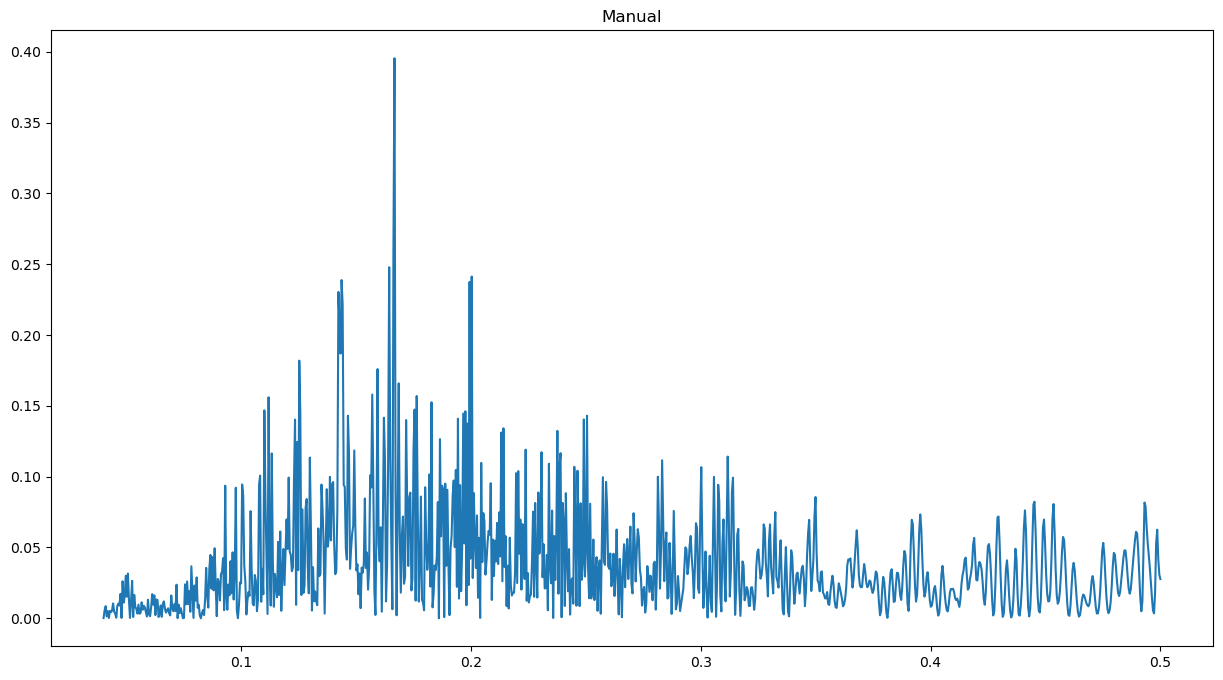

In [14]:
b.run_solver('lcperiod_manual', solution='lcperiod_manual_solution', overwrite=True)
print(b.filter(solver='lcperiod_manual'))
plt.plot(b.get_value('period@lcperiod_manual_solution'), b.get_value('power@lcperiod_manual_solution'))
plt.title("Manual")
plt.show()

In [15]:
printFittedVals(b, 'lcperiod_solution')
printFittedVals(b, 'lcperiod_manual_solution')

period@binary@orbit@component = 7.03 d
period@binary@orbit@component = 0.17 d


P_orb = 168.61160886672542 h


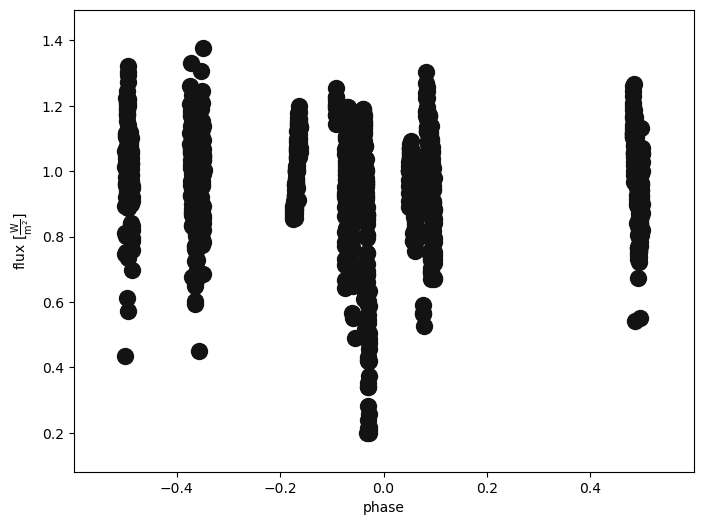

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [18]:
b.adopt_solution('lcperiod_solution')
print(f"P_orb = {b.get_quantity(qualifier='period', component='binary', unit=u.hour)}")
b.plot(x='phase', kind='lc', dataset='lc_iturbide', model=[], show=True)

P_orb = 7.998078078078079 h
P_orb = 0.3332532532532533 d


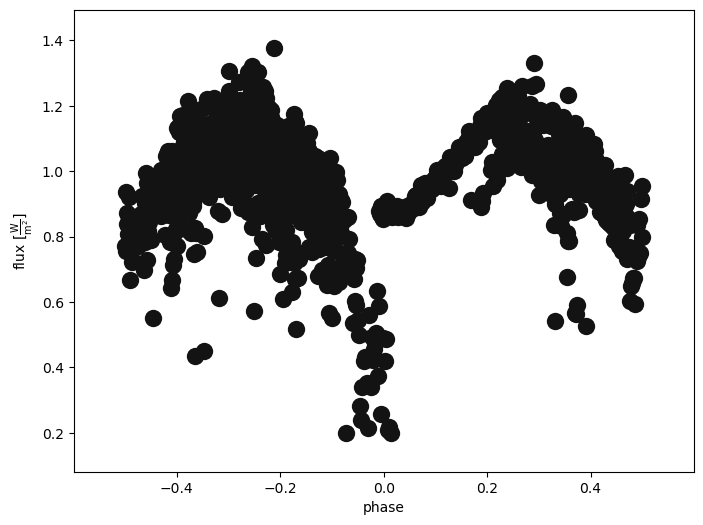

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [19]:
b.adopt_solution('lcperiod_manual_solution', period_factor=2)
print(f"P_orb = {b.get_quantity(qualifier='period', component='binary', unit=u.hour)}")
print(f"P_orb = {b.get_quantity(qualifier='period', component='binary', unit=u.day)}")
b.plot(x='phase', kind='lc', dataset='lc_iturbide', model=[], show=True)

In [ ]:
b.save("./bundle-saves/manual-periodogram")

## Default binary forward model

In [3]:
b = phoebe.load("./bundle-saves/manual-periodogram")

In [4]:
print(b['pblum'])
print(b['pblum_mode'])
print(b['q'])

Parameter: pblum@primary@lc_iturbide@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.566370614359172 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: [component]pblum_mode:decoupled||[component]pblum_mode:component-coupled,[component]pblum_component:<component>

Parameter: pblum_mode@lc_iturbide@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: q@binary@component
                       Qualifier: q
                     Description

In [5]:
# original = 4*pi W
# changed to have a proper match with observational normalized flux
b.set_value(qualifier='pblum', value=(2*np.pi)*u.W)

In [ ]:
avoidAtmosphereErrors(b)
b.run_compute(compute='fast_compute', model='fast_default_model', overwrite=True)

b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True)
animateMesh(b)

100%|██████████| 1193/1193 [01:11<00:00, 16.57it/s]


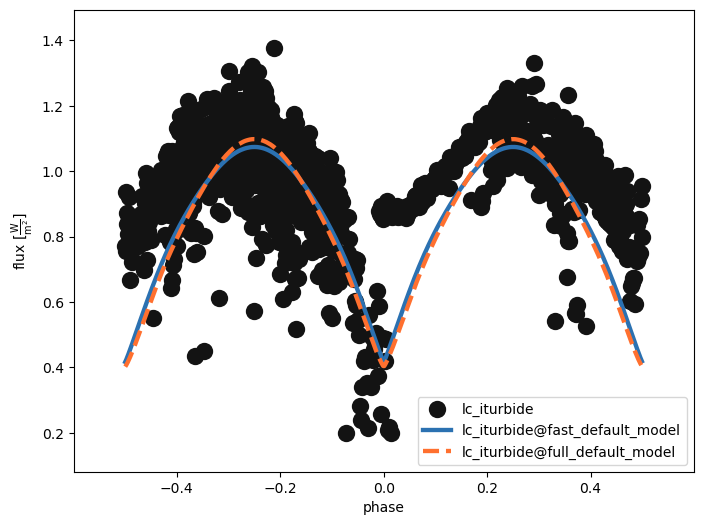

<Figure size 800x600 with 0 Axes>

In [26]:
resetAtmosphere(b)
b.run_compute(compute='phoebe01', model='full_default_model', overwrite=True)

b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True)
animateMesh(b)

In [27]:
b.save("./bundle-saves/default-fw-models")

'./bundle-saves/default-fw-models'

## Manual parameter estimates

### `q` from $P_{orb} - q$ relation
Used mean value obtained from https://github.com/Somayeh91/p_q_relations_contact_binaries. Script ran using a period of $0.3332532532532533 \space \mathrm{d}^{-1}$ obtained
from PHOEBE's Lomb-Scargle periodogram estimator.



In [9]:
b = phoebe.load("./bundle-saves/default-fw-models")

In [10]:
print(f"Original q: {b.get_value(qualifier='q')}")
q_mean = 0.4114017324225817
b.set_value(qualifier='q', value=q_mean)

Fri, 07 Jul 2023 15:18 BUNDLE       ERROR   Constraint 'pot@contact_envelope@envelope@constraint' raised the following error while attempting to solve for 'pot@contact_envelope@envelope@component'.  Consider flipping the constraint or changing the value of one of ['requiv@primary@star@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'pot@contact_envelope@envelope@component'] until the constraint succeeds.  Original error: roche_contact_Omega_at_partial_vol::Volume is outside bounds.
Fri, 07 Jul 2023 15:18 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Fri, 07 Jul 2023 15:18 BUNDL

Original q: 1.0


In [13]:
requivRatio = q_mean**0.46
requivRatio

0.6646031776766351

In [12]:
print(b['requiv'])
print(b['pot@contact_envelope'])

ParameterSet: 3 parameters
         requiv@primary@component: 1.5 solRad
C      requiv@secondary@component: 1.4999999999999996 solRad
                requiv@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  pot@contact_envelope@component: 3.4013774072298766
                   pot@constraint: requiv_to_pot_contact({requiv@primary@component}, {q@binary@component}, {sma@binary@component}, 1)
ParameterSet: 2 parameters
C  pot@contact_envelope@component: 3.4013774072298766
                   pot@constraint: requiv_to_pot_contact({requiv@primary@component}, {q@binary@component}, {sma@binary@component}, 1)


## Light curve geometry estimators

### EBAI

#### KNN

In [11]:
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn', overwrite=True)
print(b['ebai_knn'])

ParameterSet: 6 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['*']
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


In [12]:
b.run_solver('ebai_knn', solution='ebai_knn_solution', overwrite=True)

Fri, 07 Jul 2023 15:18 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Fri, 07 Jul 2023 15:18 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ramon/anaconda3/envs/mapta-tesis-310/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid

<ParameterSet: 13 parameters | qualifiers: input_phases, input_sigmas, fitted_twigs, ebai_phases, comments, input_fluxes, adopt_parameters, adopt_distributions, ebai_fluxes, orbit, fitted_units, adopt_values, fitted_values>

In [13]:
printFittedVals(b, 'ebai_knn_solution')
print()
printFittedTwigsConstraints(b, 'ebai_knn_solution')

t0_supconj@binary@orbit@component = 0.00 d
teffratio@binary@orbit@component = 0.82 
incl@binary@orbit@component = 1.42 rad
fillout_factor@contact_envelope@envelope@component = 0.37 
q@binary@orbit@component = 8.77 

ParameterSet: 1 parameters
      t0_supconj@binary@component: 0.0 d
ParameterSet: 1 parameters
C      teffratio@binary@component: 1.0
ParameterSet: 1 parameters
            incl@binary@component: 90.0 deg
ParameterSet: 1 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
ParameterSet: 1 parameters
               q@binary@component: 0.4114017324225817


In [34]:
print(b.filter(qualifier='adopt_parameters', solution='ebai_knn_solution'))

ParameterSet: 1 parameters
   adopt_parameters@ebai_knn@e...: ['t0_supconj@binary@orbit@component', 'teffratio@binary@orbit@component', 'incl@binary@orbit@component', 'fillout_factor@contact_envelope@envelope@component', 'q@binary@orbit@component']


In [38]:
print(b.filter(qualifier='logg'))
print(b.filter(qualifier='mass'))
print(b.filter(qualifier='requiv'))
print(b['q'])
print(b['teffratio'])
print(b['teff'])

ParameterSet: 4 parameters
C          logg@primary@component: 4.593506725788673
C        logg@secondary@component: 4.207772841975729
          logg@primary@constraint: log10((({mass@primary@component} / ({requiv@primary@component} ** 2.000000)) * 2942.206218) * 9.319541)
        logg@secondary@constraint: log10((({mass@secondary@component} / ({requiv@secondary@component} ** 2.000000)) * 2942.206218) * 9.319541)
ParameterSet: 4 parameters
C          mass@primary@component: 3.218263588353929 solMass
C        mass@secondary@component: 1.3239992156413207 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
ParameterS

In [29]:
print(b.get_quantity('incl@binary', unit=u.rad))
print(b['teffratio'])
print(b['fillout_factor'])
print(b['q'])
print(b['pot@contact_envelope'])
print(b['sma@binary'])
print(b['requiv@primary'])
print(b['requiv@secondary'])
print(b['requivratio'])

1.5707963267948966 rad
ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.0
                  Constrained by: 
                      Constrains: pot@contact_envelope@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@comp

In [47]:
b.flip_constraint('teffratio', solve_for='teff@primary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 2.5406064046051475>

100%|██████████| 1193/1193 [00:36<00:00, 32.69it/s]


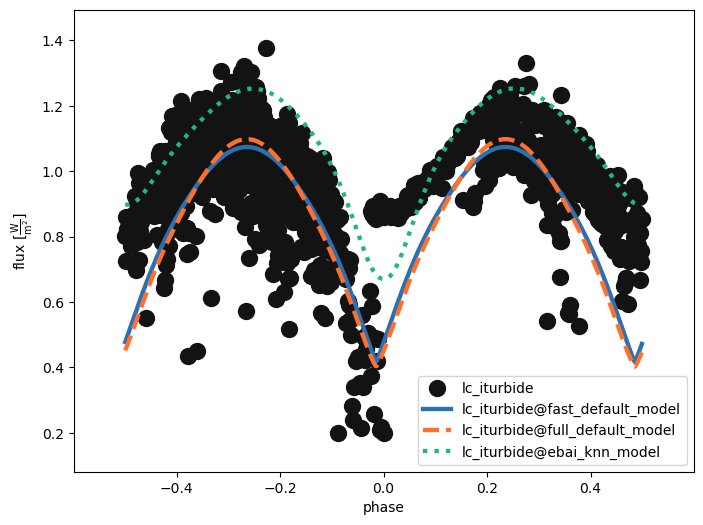

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [52]:
avoidAtmosphereErrors(b)

# adopting all parameters except for q
b.adopt_solution('ebai_knn_solution', 
	adopt_parameters=['t0_supconj@binary@orbit@component', 'teffratio@binary@orbit@component', 'incl@binary@orbit@component', 'fillout_factor@contact_envelope@envelope@component'])

b.set_value(qualifier='pblum', value=(4*np.pi)*u.W) # resetting to default, since it looks to be going too low
b.run_compute(compute='fast_compute', model='ebai_knn_model', overwrite=True)
b.plot(x='phase', kind='lc', show=True, legend=True)
# animateMesh(b)
# animateMesh(b, component='primary')
# animateMesh(b, component='secondary')

In [55]:
print(b['mass'])
print(b['requiv'])
print(b['teffratio'])
print(b['teff'])
print(b['period@binary'])
print(b['fillout_factor'])
print(b.get_quantity('period@binary', unit=u.hour))

ParameterSet: 4 parameters
C          mass@primary@component: 3.218263588353929 solMass
C        mass@secondary@component: 1.3239992156413207 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
ParameterSet: 4 parameters
C        requiv@primary@component: 1.62223698197651 solRad
C      requiv@secondary@component: 1.110767191144792 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)

100%|██████████| 1193/1193 [01:30<00:00, 13.14it/s]


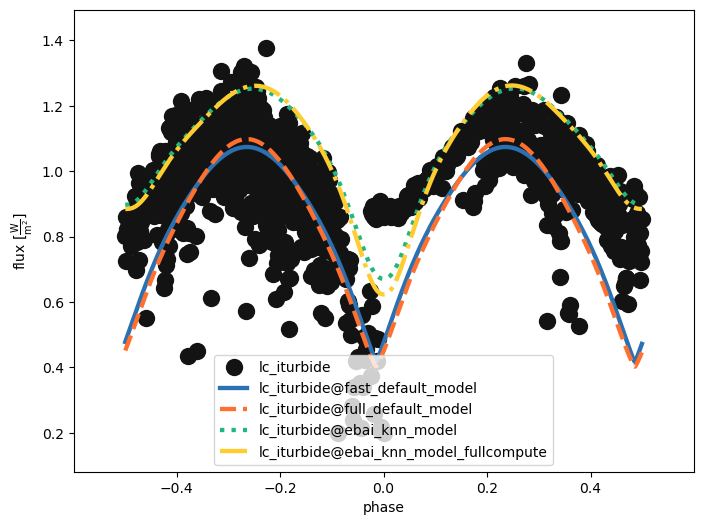

(<autofig.figure.Figure | 1 axes | 5 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [56]:
resetAtmosphere(b)
b.run_compute(compute='phoebe01', model='ebai_knn_model_fullcompute', overwrite=True)
b.plot(x='phase', kind='lc', show=True, legend=True)
# animateMesh(b)
# animateMesh(b, component='primary')
# animateMesh(b, component='secondary')

In [38]:
%%script echo "skipping due to different estimated parameters now; no radiative atmospheres as of now"

print(b['gravb_bol'])
print(b['irrad_frac_refl_bol'])

# values recommended by PHOEBE when running forward compute
# b.set_value(qualifier='gravb_bol', component='primary', value=0.9)
# b.set_value(qualifier='irrad_frac_refl_bol', component='primary', value=1.0)

skipping due to different estimated parameters now


In [57]:
saveBundle(b, "pre-nm-opt")

'bundle-saves/pre-nm-opt'

## Optimizers

### Nelder-Mead

#### Fast compute

In [78]:
# start with a bundle where estimators have been run, but no optimizers
b = phoebe.load("./bundle-saves/pre-nm-opt")

In [39]:
# TODO: run locally with 400 maxiter
b.add_solver('optimizer.nelder_mead',  solver='opt_nm_fast', compute='fast_compute', maxiter=1000, overwrite=True,
             fit_parameters=['t0_supconj@binary', 'incl@binary'])
print(b['opt_nm_fast'])

print(b['xatol@opt_nm_fast'])
print(b['fatol@opt_nm_fast'])
print(b['expose_lnprobabilities'])

ParameterSet: 13 parameters
      comments@opt_nm_fast@solver: 
    use_server@opt_nm_fast@solver: compute
       compute@opt_nm_fast@solver: fast_compute
   expose_lnprobabilities@opt_...: False
   continue_from@opt_nm_fast@s...: None
   fit_parameters@opt_nm_fast@...: ['t0_supconj@binary', 'incl@binary', 'q']
   initial_values@opt_nm_fast@...: {}
        priors@opt_nm_fast@solver: []
       maxiter@opt_nm_fast@solver: 1000
      adaptive@opt_nm_fast@solver: False
         xatol@opt_nm_fast@solver: 0.0001
         fatol@opt_nm_fast@solver: 0.0001
   progress_every_niters@opt_n...: 0
Parameter: xatol@opt_nm_fast@solver
                       Qualifier: xatol
                     Description: passed directly to scipy.optimize.minimize.  Absolute error in xopt (input parameters) between iterations that is acceptable for convergence.
                           Value: 0.0001
                  Constrained by: 
                      Constrains: None
                      Related to: None

Pa

In [44]:
avoidAtmosphereErrors(b)
b.export_solver(script_fname='./external-jobs/opt_nm_fast.py', out_fname='./results/opt_nm_fast_solution', solver='opt_nm_fast', solution='opt_nm_fast_solution', use_server='none')

('./external-jobs/opt_nm_fast.py', './results/opt_nm_fast_solution')

In [79]:
RUN_LOCAL = False

if RUN_LOCAL:
	avoidAtmosphereErrors(b)
	logger.setLevel('ERROR')
	b.run_solver('opt_nm_fast', solution='opt_nm_fast_solution', overwrite=True)
	logger.setLevel('WARNING')
else:
	b.import_solution(fname='./external-jobs/results/opt_nm_fast_solution', overwrite=True)

In [55]:
print(b['opt_nm_fast_solution'], '\n')
printFittedVals(b, 'opt_nm_fast_solution')

ParameterSet: 11 parameters
R  fitted_twigs@fast_compute@o...: ['t0_supconj@binary@orbit@component' 'incl@binary@orbit@component'
 'q@binary@orbit@component']
   adopt_parameters@fast_compu...: ['t0_supconj@binary@orbit@component', 'incl@binary@orbit@component', 'q@binary@orbit@component']
   adopt_distributions@fast_co...: False
   adopt_values@fast_compute@o...: True
R  message@opt_nm_fast_solutio...: Optimization terminated successfully.
R  niter@opt_nm_fast_solution@...: 99
R  success@opt_nm_fast_solutio...: True
R  initial_values@opt_nm_fast_...: [0.004832585130643857 81.4958348186482 8.76878904542343]
R  fitted_values@fast_compute@...: [-0.007740596802086735 108.40327876992488 9.654956485256186]
R  fitted_units@fast_compute@o...: ['d' 'deg' '']
   comments@fast_compute@opt_n...:  

t0_supconj@binary@orbit@component = -0.01 d
incl@binary@orbit@component = 108.40 deg
q@binary@orbit@component = 9.65 


Tue, 04 Jul 2023 12:31 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Tue, 04 Jul 2023 12:31 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value












































































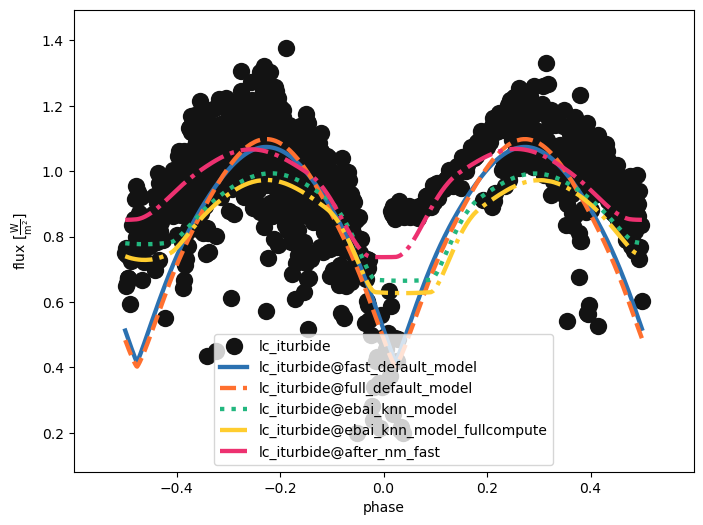

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [80]:
b.adopt_solution('opt_nm_fast_solution')
b.run_compute('fast_compute', model='after_nm_fast', overwrite=True)
b.plot(x='phase', kind='lc', show=True, legend=True)
# b.plot(x='phase', y='residuals', show=True, legend=True)

animateMesh(b)
animateMesh(b, component='primary')
animateMesh(b, component='secondary')

In [65]:
print(b['mass'])
print(b['requiv'])
print(b['teffratio'])
print(b['teff'])
print(b['period'])
print(b['fillout_factor'])
print(b.get_quantity('period@binary', unit=u.hour))

ParameterSet: 4 parameters
C          mass@primary@component: 1.2826632852762119 solMass
C        mass@secondary@component: 3.2595995187190376 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
ParameterSet: 4 parameters
C        requiv@primary@component: 1.0971895408384702 solRad
C      requiv@secondary@component: 1.6337196115152457 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}

#### Full compute

In [67]:
b = phoebe.load("./bundle-saves/pre-nm-opt")
b.add_solver('optimizer.nelder_mead',  solver='opt_nm_full', compute='phoebe01', maxiter=1000, overwrite=True,
             fit_parameters=['t0_supconj@binary', 'incl@binary', 'q'])

resetAtmosphere(b)
b.export_solver(script_fname='./external-jobs/opt_nm_full.py', out_fname='./results/opt_nm_full_solution', solver='opt_nm_full', 
                solution='opt_nm_full_solution', use_server='none')

('./external-jobs/opt_nm_full.py', './results/opt_nm_full_solution')

In [81]:
RUN_LOCAL = False

if RUN_LOCAL:
	resetAtmosphere(b)
	logger.setLevel('ERROR')
	b.run_solver('opt_nm_full', solution='opt_nm_full_solution', overwrite=True)
	logger.setLevel('WARNING')
else:
	b.import_solution(fname='./external-jobs/results/opt_nm_full_solution', overwrite=True)

printFittedVals(b, 'opt_nm_full_solution')

t0_supconj@binary@orbit@component = 0.00 d
incl@binary@orbit@component = 73.92 deg
q@binary@orbit@component = 10.14 


Tue, 04 Jul 2023 15:36 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value
Tue, 04 Jul 2023 15:36 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential < L2/L3 critical value












































































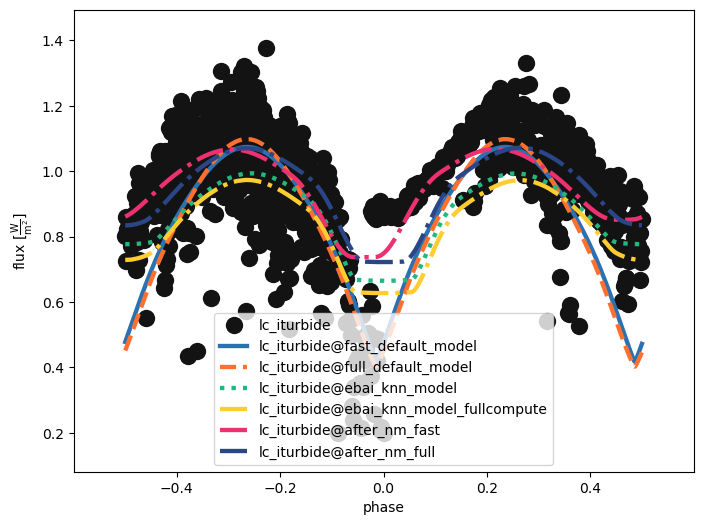

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [82]:
resetAtmosphere(b)
b.adopt_solution('opt_nm_full_solution')
b.run_compute(compute='phoebe01', model='after_nm_full', overwrite=True)
b.plot(x='phase', kind='lc', show=True, legend=True)
animateMesh(b)
animateMesh(b, component='primary')
animateMesh(b, component='secondary')